In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TUXML_CSV_FILENAME="./config_bdd.csv"
rawtuxdata = pd.read_csv(open(TUXML_CSV_FILENAME, "r"))

basic_head = ["cid", "time", "compile", "vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]


size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]

tri_state_values = ['y', 'n', 'm']

ftuniques = []
freq_ymn_features = []
non_tristate_options = []

for col in rawtuxdata:
    ft = rawtuxdata[col]    
    # eg always "y"
    if len(ft.unique()) == 1:
        ftuniques.append(col)
    # only tri-state values (y, n, m) (possible TODO: handle numerical/string options)    
    elif all(x in tri_state_values for x in ft.unique()):     #len(ft.unique()) == 3: 
        freq = ft.value_counts(normalize=True)
        freqy = 0
        freqn = 0
        freqm = 0
        if ('y' in freq.index):
            freqy = freq['y']
        if ('n' in freq.index):
            freqn = freq['n']
        if ('m' in freq.index):
            freqm = freq['m']
        freq_ymn_features.append((col, freqy, freqm, freqn))
        # categorical variable
        #if tuxdata[col].dtype == 'object':
        #    try:
        #        tuxdata[col] = tuxdata[col].astype('category')
        #    except:
        #        print('Column', ' ', col, ' cannot be converted to category.')
    else:
        if not (col in size_methods): 
            non_tristate_options.append(col)
        

### TODO: we want to keep all quantitative values!
# non_tristate_options.remove('LZO') # ('vmlinux')

# we want to keep measurements (that are not tristate ;)) 
# non_tristate_options = list(set(non_tristate_options) - set(size_methods))

#### print options with unique values
# options with only one value eg always "y"
#i = 0
#for ft in ftuniques:
#    print(ft + " (" + str(i) + ")")
#    i = i + 1

print("Original size (#configs/#options) of the dataset " + str(rawtuxdata.shape))
print ("Number of options with only one value (eg always y): " + str(pd.DataFrame(ftuniques).shape))
# maybe we can drop options with only one unique value (no interest for machine learning)
rawtuxdata.drop(columns=ftuniques,inplace=True)

print ("Non tri-state value options (eg string or integer or hybrid values): " 
       + str(pd.DataFrame(non_tristate_options).shape) + " ") 
#      + str(pd.DataFrame(non_tristate_options)))

print ("Predictor variables: " + str(rawtuxdata.drop(columns=non_tristate_options).columns.size))
# frequency of y, m, and n values 
#plt.figure()
#pd.DataFrame(freq_ymn_features, columns=["feature", "freqy", "freqm", "freqn"]).plot(kind='hist', alpha=0.8) #plot()
#plt.show()
    



/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2189,11858,12250,12340,12341,12364,12369,12378,12384) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original size (#configs/#options) of the dataset (25542, 12819)
Number of options with only one value (eg always y): (3150, 1)
Non tri-state value options (eg string or integer or hybrid values): (173, 1) 
Predictor variables: 9496


In [2]:
# playing a bit with the data 
rawtuxdata.dtypes
# 'DEBUG_INFOO' in list(pd.DataFrame(non_tristate_options)[0]) # 
# tuxdata['DEBUG_INFO'].unique()
#tuxdata['OUTPUT_FORMAT'].dtypes
#tuxdata['DEFAULT_HOSTNAME'].unique()

#rawtuxdata[:5]
rawtuxdata[:20]
#tuxdata[:5]['CONFIG_DEBUG_INFO']
#tuxdata['ARCH_HAS_SG_CHAIN'].unique()
#tuxdata['ARCH_HAS_SG_CHAIN'].astype('category')

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,SG_SPLIT,SG_POOL,ARCH_HAS_SG_CHAIN,ARCH_HAS_PMEM_API,ARCH_HAS_UACCESS_FLUSHCACHE,ARCH_HAS_MMIO_FLUSH,STACKDEPOT,SBITMAP,PARMAN,PRIME_NUMBERS
0,50510,2018-06-15 03:51:16,666.633,28236896,5604912,7692936,5373537,9750064,11837536,5400956,...,n,y,y,y,y,y,n,y,y,n
1,50511,2018-06-15 03:51:29,334.949,35342744,8241104,10327504,8093243,11874256,13960104,7609032,...,y,y,y,y,y,y,y,y,n,m
2,50512,2018-06-15 03:51:53,636.122,34624152,11195344,13280376,11048829,14967760,17052240,10705167,...,n,y,y,y,y,y,y,y,n,y
3,50513,2018-06-15 03:51:54,275.014,38339072,9479728,11565960,9315307,13149744,15235424,8866696,...,y,n,y,y,y,y,n,n,y,n
4,50514,2018-06-15 03:52:10,513.886,41650560,6066128,8152528,5917772,10112976,12198824,5847531,...,n,n,y,y,y,y,n,n,n,n
5,50515,2018-06-15 03:52:17,156.550,25481312,5149648,7235024,5003612,9110480,11195304,4844682,...,y,n,y,y,y,y,y,n,y,n
6,50516,2018-06-15 03:52:28,297.386,50641216,12054992,14140880,11908755,15540688,17626024,11276777,...,n,n,y,y,y,y,y,y,n,n
7,50517,2018-06-15 03:52:31,338.179,149856048,20436432,22520960,20290416,23680464,25764432,19415412,...,n,y,y,y,y,y,y,y,n,n
8,50518,2018-06-15 03:52:34,321.745,100119848,17727952,19815288,17517449,21631440,23718224,17303819,...,y,y,y,y,y,y,y,y,y,n
9,50519,2018-06-15 03:52:43,318.600,132791616,5870544,7957160,5670268,9966544,12052608,5646977,...,n,y,y,y,y,y,n,y,n,n


In [3]:
rawtuxdata.shape, rawtuxdata[rawtuxdata['vmlinux'] != -1].shape

((25542, 9669), (23893, 9669))

<Figure size 432x288 with 0 Axes>

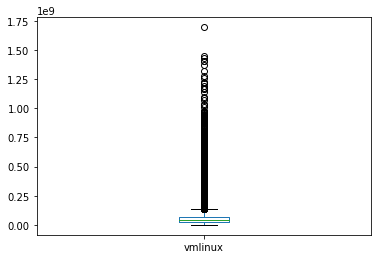

<Figure size 432x288 with 0 Axes>

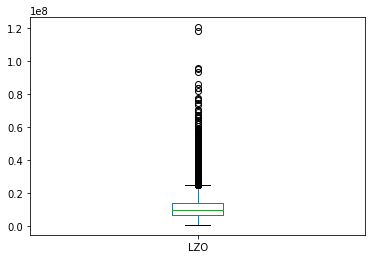

count    2.389300e+04
mean     7.078330e+07
std      9.409393e+07
min      1.168072e+06
25%      2.864443e+07
50%      4.316601e+07
75%      7.289843e+07
max      1.693674e+09
Name: vmlinux, dtype: float64

In [4]:
plt.figure()
pd.DataFrame(rawtuxdata[rawtuxdata['vmlinux'] != -1]['vmlinux']).plot.box()
plt.show()

plt.figure()
pd.DataFrame(rawtuxdata[rawtuxdata['vmlinux'] != -1]['LZO']).plot.box()
plt.show()


rawtuxdata[rawtuxdata['vmlinux'] != -1]['vmlinux'].describe()


In [5]:
import scipy.stats
import seaborn as sns



def color_negative_positive(val, pcolor="green", ncolor="red"):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = pcolor if val > 0 else ncolor 
    if val == 0:
        color = 'black' 
    return 'color: %s' % color

compress_methods = ["GZIP", "BZIP2", "LZMA", "XZ", "LZO", "LZ4"]
def compareCompress(size_measure_of_interest): #"" # "-vmlinux" #"-bzImage" # prefix
    rCompressDiff = pd.DataFrame(index=list(map(lambda c: c + "o", compress_methods)) , columns=compress_methods) 
    for compress_method in compress_methods:
        for compress_method2 in compress_methods:
            rCompressDiff.loc[compress_method + "o"][compress_method2] = (np.mean(rawtuxdata[compress_method + size_measure_of_interest] / rawtuxdata[compress_method2 + size_measure_of_interest]) * 100) - 100
    return rCompressDiff

#cmy = sns.light_palette("red", as_cmap=True)
compareCompress("").style.set_caption('Difference (average in percentage) per compression methods').applymap(color_negative_positive)

#(rawtuxdata["XZ-vmlinux"] - rawtuxdata["BZIP2-vmlinux"]).plot.box()
# n_size_methods = len(size_methods)
#corr_sizes = [[0 for x in range(n_size_methods)] for y in range(n_size_methods)]
#i = 0
#j = 0
#for size_method in size_methods:
#    csize = rawtuxdata[size_method]   
#    for osize_method in size_methods:
#        if size_method != osize_method:
#            osize = rawtuxdata[osize_method]           
#            pcorr = scipy.stats.pearsonr(csize, osize)[0]
#            corr_sizes[i][j] = pcorr
#        j = j + 1
#    i = i + 1

,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,2.70232,23.5046,36.7978,-9.67153,-15.4246
BZIP2o,-2.54583,0,20.3208,33.2106,-11.9961,-17.6089
LZMAo,-18.7167,-16.5563,0,10.6312,-26.4208,-31.0096
XZo,-32802.2,-32800.3,-32785.3,0,-33.0517,-37.1877
LZOo,-62598.9,-62596,-62572.6,51.9919,0,-6.44405
LZ4o,-68349.8,-68346.7,-68321.5,62.8847,6.9388,0


In [6]:
compareCompress("-bzImage").style.set_caption('Difference (average in percentage) per compression methods, bzImage').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-29.2098,23.1094,35.8168,-9.35868,-15.1451
BZIP2o,46.5635,0,80.615,99.2107,32.6389,24.014
LZMAo,-18.4619,-42.0679,0,10.1945,-25.9389,-30.5708
XZo,-25.5922,-47.0297,-8.88287,0,-32.3679,-36.56
LZOo,10.4757,-21.9518,36.2475,50.3642,0,-6.45666
LZ4o,18.2443,-16.5701,45.981,61.153,6.95246,0


In [7]:
compareCompress("-vmlinux").style.set_caption('Difference (average in percentage) per compression methods, vmlinux').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-24.6003,17.8225,26.9045,-7.66119,-12.5458
BZIP2o,35.1473,0,59.0805,71.243,24.7609,18.1227
LZMAo,-14.8527,-35.7667,0,7.5982,-21.2459,-25.3314
XZo,-20.5797,-40.0596,-6.83596,0,-26.5027,-30.2859
LZOo,8.41463,-18.3007,27.9368,37.8507,0,-5.34926
LZ4o,14.6582,-13.6266,35.4342,45.9698,5.6928,0


In [8]:
cm = sns.light_palette("green", as_cmap=True)
pd.DataFrame.corr(rawtuxdata[size_methods]).style.set_caption('Correlations between size measures').background_gradient(cmap=cm)


,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,LZMA-bzImage,LZMA-vmlinux,LZMA,XZ-bzImage,XZ-vmlinux,XZ,LZO-bzImage,LZO-vmlinux,LZO,LZ4-bzImage,LZ4-vmlinux,LZ4
vmlinux,1,0.505584,0.503872,0.503962,0.511769,0.505525,0.517116,0.495625,0.492304,0.493506,0.499828,0.496416,0.49874,0.51941,0.518352,0.519134,0.524615,0.523863,0.524443
GZIP-bzImage,0.505584,1,0.997555,0.999836,0.987996,0.977297,0.997443,0.997811,0.9917,0.997745,0.994727,0.98902,0.994717,0.997326,0.996282,0.997412,0.994484,0.994148,0.994574
GZIP-vmlinux,0.503872,0.997555,1,0.997001,0.99532,0.988926,0.994758,0.997019,0.997258,0.996473,0.993253,0.994403,0.992689,0.994133,0.997374,0.993901,0.990874,0.994462,0.99065
GZIP,0.503962,0.999836,0.997001,1,0.986959,0.975923,0.997433,0.997461,0.990847,0.997829,0.994596,0.988338,0.994657,0.99724,0.995751,0.997261,0.99438,0.993619,0.994395
BZIP2-bzImage,0.511769,0.987996,0.99532,0.986959,1,0.997792,0.989645,0.988349,0.994979,0.987194,0.984938,0.992935,0.983608,0.987313,0.994711,0.986621,0.985337,0.992686,0.98467
BZIP2-vmlinux,0.505525,0.977297,0.988926,0.975923,0.997792,1,0.978577,0.979149,0.991393,0.977579,0.975122,0.989175,0.973315,0.975853,0.98702,0.974889,0.973472,0.984269,0.972535
BZIP2,0.517116,0.997443,0.994758,0.997433,0.989645,0.978577,1,0.994311,0.987935,0.994445,0.992484,0.98643,0.992296,0.998525,0.997066,0.998404,0.997463,0.996688,0.997351
LZMA-bzImage,0.495625,0.997811,0.997019,0.997461,0.988349,0.979149,0.994311,1,0.99587,0.999713,0.994985,0.9915,0.994841,0.991694,0.992213,0.991724,0.987299,0.988431,0.987333
LZMA-vmlinux,0.492304,0.9917,0.997258,0.990847,0.994979,0.991393,0.987935,0.99587,1,0.994962,0.990055,0.995484,0.98919,0.984762,0.990838,0.984378,0.979898,0.986115,0.979522
LZMA,0.493506,0.997745,0.996473,0.997829,0.987194,0.977579,0.994445,0.999713,0.994962,1,0.994978,0.990812,0.994924,0.991714,0.991675,0.991656,0.987286,0.987885,0.987217


In [9]:
#from category_encoders import *
from sklearn.preprocessing import *

#X = [['y', 1], ['n', 3], ['m', 2]]
#enc.fit(X)
#enc.transform(tuxdata)

#enc = OrdinalEncoder().fit(tuxdata[:10])

# transform the dataset
#enc.transform(tuxdata[:10])

# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()


# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
#print(non_tristate_options)

# we save quantitative values we want (here vmlinux, TODO: generalize)
# the key idea is that the labelling encoder should not be applied to this kind of values (only to predictor variables!)
# vml = rawtuxdata['LZO'] # rawtuxdata['vmlinux'] 
vml = rawtuxdata[size_methods]

# we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
#tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(le.fit_transform)

#tuxdata['vmlinux'] = vml 
tuxdata[size_methods] = vml
# tuxdata['vmlinux'].astype('int64')

# example: DEBUG_INFO is either y or n
tuxdata['DEBUG_INFO'].unique()

array([0, 1])

In [10]:
# remove entries with same configurations
print(str(len(tuxdata)) + " before the removal of some entries (those with same configurations)")
# tuxdata.drop_duplicates(subset=tuxdata.columns.difference(['vmlinux']), inplace=True)
tuxdata.drop_duplicates(subset=tuxdata.columns.difference(size_methods), inplace=True)
print(str(len(tuxdata)) + " after the removal of some entries (those with same configurations)")

25542 before the removal of some entries (those with same configurations)
25046 after the removal of some entries (those with same configurations)


In [11]:
#n_failures = len(tuxdata[~np.isnan(tuxdata['vmlinux'])])
n_failures = len(tuxdata[tuxdata['vmlinux'] == -1]) #len(tuxdata[np.isnan(tuxdata['vmlinux'])])
print(str(n_failures) + " failures out of " + str(len(tuxdata)))

#tuxdata = tuxdata[~np.isnan(tuxdata['vmlinux'])]
tuxdata = tuxdata[tuxdata['vmlinux'] != -1] #tuxdata[~np.isnan(tuxdata['vmlinux'])]
print(str(len(tuxdata)) + " after the removal of configurations that do NOT compile")

#tuxdata["vmlinux"]
#tuxdata.where(tuxdata["vmlinux"] == np.NaN)

#tuxdata[tuxdata["vmlinux"] != -1]
#tuxdata
#tuxdata[tuxdata['vmlinux'] != -1].shape

1612 failures out of 25046
23434 after the removal of configurations that do NOT compile


In [12]:
# tuxdata.where(not np.isnan(tuxdata["vmlinux"]))
#tuxdata["vmlinux"][16] == np.isnan
#vml == -1 
#tuxdata["vmlinux"] == -1
#tuxdata['vmlinux'].dtypes
#vml.dtypes
#tuxdata['vmlinux'].dtypes #.astype('int64')
#TODO: remove configurations like this 
#tuxdata[tuxdata['X86_64'] == 'n']
tuxdata['X86_64'].describe()

count    23434.000000
mean         0.999872
std          0.011314
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: X86_64, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model



TESTING_SIZE=0.3 

# drop(columns=["date", "time", "vmlinux", "cid"])
# tuxdata.drop(columns=non_tristate_options)

linearRegression=True
size_of_interest = "vmlinux" # could be LZO, BZIP, etc. 

X_train, X_test, y_train, y_test = train_test_split(tuxdata.drop(columns=size_methods), tuxdata[size_of_interest], test_size=TESTING_SIZE, random_state=0)  

# train_test_split(tuxdata.drop(columns=['vmlinux']), tuxdata['vmlinux'], test_size=TESTING_SIZE, random_state=0)  

#clf = RandomForestRegressor(n_estimators=100) 

if linearRegression:
    regr = linear_model.SGDRegressor #LinearRegression() # SGDRegressor or Lasso
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
else:
    clf = GradientBoostingRegressor(n_estimators=100)  # 
    #clf = Pipeline([
    #  ('feature_selection', SelectFromModel(LassoCV())),
    #  ('regression', GradientBoostingRegressor(n_estimators=100))
    # ])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]    

    TOP_FT_IMPORTANCE=20
    print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
    for f in range(TOP_FT_IMPORTANCE): # len(indices)
        print("%d. feature %s %d (%f)" % (f + 1, tuxdata.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
#plt.figure()
#plt.title("Feature importances for size of vmlinux")
#plt.bar(range(tuxdata.shape[1]), importances[indices], color="r", align="center")
#plt.xticks(range(tuxdata.shape[1]), indices)
#plt.xlim([-1, tuxdata.shape[1]])
#plt.show()
mae = mean_absolute_error (y_test, y_pred)
mse = mean_squared_error (y_test, y_pred) 
r2 = r2_score (y_test, y_pred) 
print("Prediction score (MAE): %.2f" % (mae))
print("Prediction score (MSE): %.2f" % (mse))
print("Prediction score (R2): %.2f" % (r2))


In [14]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(clf, prefit=True)
tuxdata_reduced = model.transform(tuxdata.drop(columns=size_methods))
tuxdata_reduced.shape, tuxdata.shape


((23434, 458), (23434, 9496))

In [15]:
ft_vals = ['y', 'n'] 
tri_state_values = ['y', 'n', 'm']
all(x in tri_state_values for x in ft_vals)

True

In [16]:
# tuxdata.where(tuxdata["vmlinux"] != -1).sort_values(by='vmlinux')[:5] # & 

In [17]:
#for tux1 in tuxdata:
#    ft1 = tuxdata[tux1]
#    for tux2 in tuxdata:
#        if (tux1 != tux2):
#            if (ft1.all() == tuxdata[tux2].all()):
#                print ("feature " + str(tux1) + " always have the same values than " + str(tux2))
            
    